Simulate the incoming tcp packets as raw bytes,  allocating GPU memory for raw bytes, copy the gpu memory containing these raw bytes to torch and convert to image tensor followed by processing and inference.

1. Load an image in host.
2. convert it to raw bytes data similar to how we might recieve from smartnic.
3. allocate gpu memory and move this raw bytes data to gpu memory.
4. so far, we have image raw data in gpu memory.
5. Create a random value torch byte tensor in GPU.
6. copy from  gpu_memory to this byte tensor address.
7. Convert this tensor to image tensor for rest of the processing and inference.

Note: since pytorch cant access the memory pointer directly, we use pycuda to copy the raw bytes data from memory pointer (passed by smartnic) to a new torch zeros byte tensor (in GPU only).we use this tensor for rest of the flow.


In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660545 sha256=4a149d4b1344b27c4f181ba306aea0125818929487f9a8953898c18832e405e9
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


In [ ]:
import torch
import numpy as np
import ctypes
import torch
import pycuda.driver as cuda
import pycuda.autoinit

class_names = ["person", "bicycle", "car", "motorbike", "airplane", "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
    "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
    "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
    "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush"]

In [ ]:
def load_yolov5_model():
    # Load YOLOv5 model (can be replaced with other variants like yolov5m, yolov5l)
    model = torch.hub.load('ultralytics/yolov5:v6.2', 'yolov5s')
    model = model.cuda()  # Move model to GPU
    return model

# Run inference using PyTorch (YOLOv5)
def infer_on_gpu(model, image_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    return predictions


def postprocess(predictions, conf_threshold=0.5):
    pred = predictions[0]
    boxes = pred[:, :4]  # Bounding box coordinates
    confidences = pred[:, 4]  # Confidence scores
    class_probs = pred[:, 5:]  # Class probabilities

    # Get predicted class ID
    class_ids = torch.argmax(class_probs, dim=1)
    overall_confidences = confidences * class_probs.max(dim=1).values

    keep = overall_confidences > conf_threshold
    boxes = boxes[keep]
    confidences = overall_confidences[keep]
    class_ids = class_ids[keep]

    # Print boxes, confidences, and class ids
    for i in range(len(boxes)):
        print(f"Box {i}: {boxes[i]}, Confidence: {confidences[i].item():.2f}, Class ID: {class_ids[i].item()}")

    return boxes, confidences, class_ids

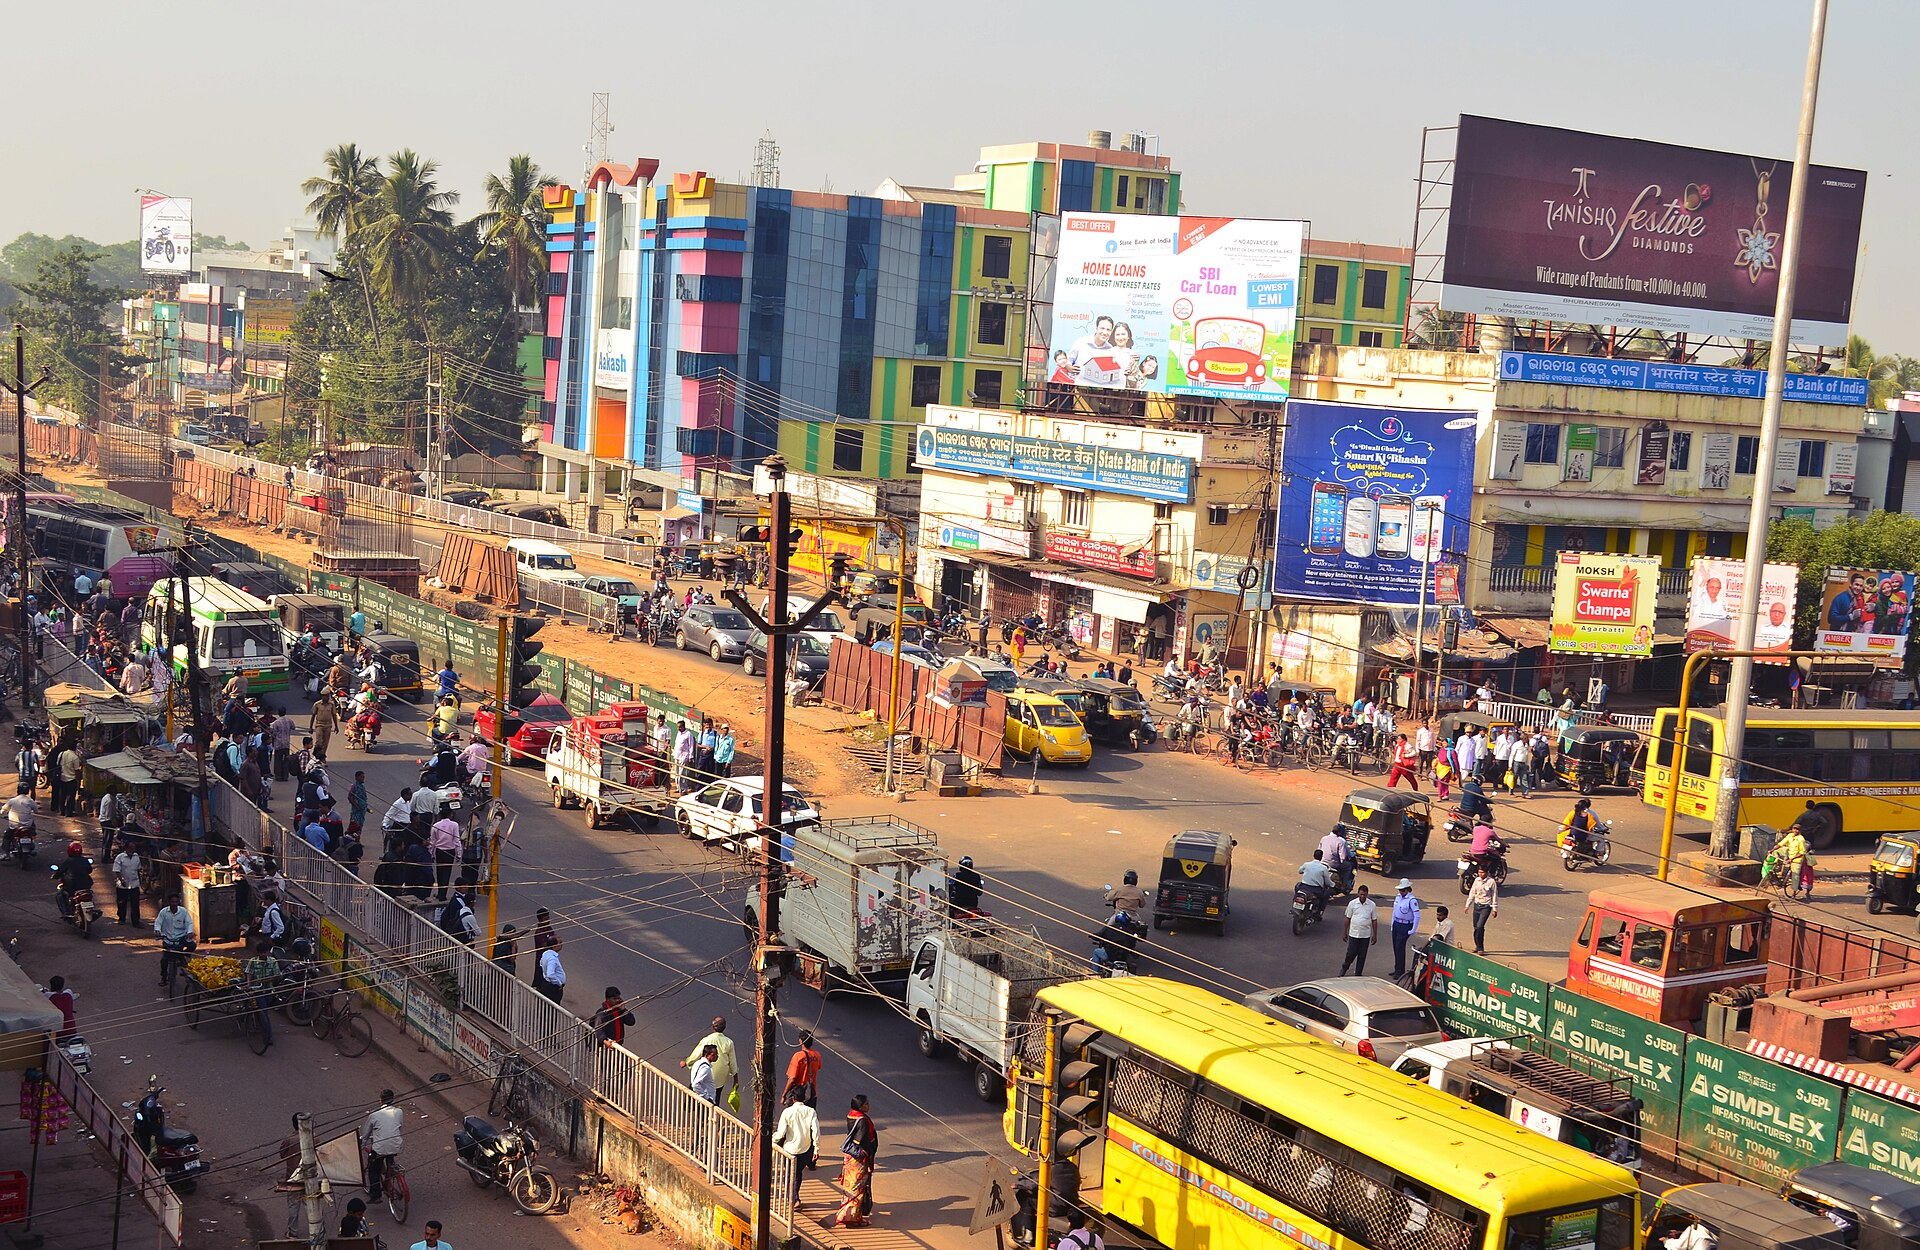

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
#!wget -O spg4.jpg http://spg.nic.in/images/SPGslide4.jpg
raw_image_data = cv2.imread('Link_Road_Cuttack.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(raw_image_data)

In [ ]:
raw_image_data.shape , raw_image_data

((1250, 1920, 3),
 array([[[216, 221, 222],
         [216, 221, 222],
         [216, 221, 222],
         ...,
         [211, 205, 198],
         [210, 204, 197],
         [209, 203, 196]],
 
        [[216, 221, 222],
         [216, 221, 222],
         [216, 221, 222],
         ...,
         [211, 205, 198],
         [210, 204, 197],
         [210, 204, 197]],
 
        [[216, 221, 222],
         [216, 221, 222],
         [216, 221, 222],
         ...,
         [211, 205, 198],
         [211, 205, 198],
         [210, 204, 197]],
 
        ...,
 
        [[ 34,  27,  32],
         [ 35,  28,  31],
         [ 37,  30,  33],
         ...,
         [ 27,  25,  31],
         [ 27,  25,  31],
         [ 25,  23,  29]],
 
        [[ 35,  28,  35],
         [ 36,  30,  35],
         [ 36,  29,  32],
         ...,
         [ 23,  23,  29],
         [ 23,  24,  28],
         [ 24,  25,  29]],
 
        [[ 35,  28,  35],
         [ 36,  30,  35],
         [ 36,  29,  34],
         ...,
         [

In [ ]:
# Step 1: Simulate receiving raw byte data (this would be the image TCP packet data)
height, width, channels = raw_image_data.shape  # Image dimensions
image_size = height * width * channels  # Total number of bytes for image

raw_image_data_bytes = raw_image_data.tobytes()
raw_image_data.shape, len(raw_image_data_bytes)

((1250, 1920, 3), 7200000)

In [ ]:
raw_image_data_bytes[:100]

b'\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd8\xdd\xde\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7\xdc\xdd\xd7'

In [ ]:
# Step 2: Allocate GPU memory for the raw byte stream
gpu_memory = cuda.mem_alloc(image_size)  # Allocate GPU memory for the raw byte data

# Step 3: Copy the raw byte data to GPU memory
cuda.memcpy_htod(gpu_memory, raw_image_data_bytes)  # Copy from host to device

### Uptill now is creating a raw data bytes in GPU : assumption is : this will be available in GPU written by smartnic.

In [ ]:
# Step 4: Create a dummy PyTorch ByteTensor on the GPU directly from raw byte data
image_tensor = torch.cuda.ByteTensor(image_size)  # Allocate ByteTensor on GPU

In [ ]:
image_tensor

tensor([ 52,  66, 185,  ..., 182, 203,  57], device='cuda:0', dtype=torch.uint8)

In [ ]:
cuda.memcpy_dtod(image_tensor.data_ptr(), gpu_memory, image_size)  # Copy the raw data bytes to this dummy byte tensor

In [ ]:
image_tensor

tensor([216, 221, 222,  ...,  25,  26,  30], device='cuda:0', dtype=torch.uint8)

In [ ]:
# Step 5: Reshape the tensor (to image dimensions)
image_tensor = image_tensor.view(height, width, channels)  # Reshape to HWC format

# Now you have the raw image data as a PyTorch tensor on the GPU
print(image_tensor.shape)  # Check the shape to confirm

torch.Size([1250, 1920, 3])


In [ ]:
image_tensor

tensor([[[216, 221, 222],
         [216, 221, 222],
         [216, 221, 222],
         ...,
         [211, 205, 198],
         [210, 204, 197],
         [209, 203, 196]],

        [[216, 221, 222],
         [216, 221, 222],
         [216, 221, 222],
         ...,
         [211, 205, 198],
         [210, 204, 197],
         [210, 204, 197]],

        [[216, 221, 222],
         [216, 221, 222],
         [216, 221, 222],
         ...,
         [211, 205, 198],
         [211, 205, 198],
         [210, 204, 197]],

        ...,

        [[ 34,  27,  32],
         [ 35,  28,  31],
         [ 37,  30,  33],
         ...,
         [ 27,  25,  31],
         [ 27,  25,  31],
         [ 25,  23,  29]],

        [[ 35,  28,  35],
         [ 36,  30,  35],
         [ 36,  29,  32],
         ...,
         [ 23,  23,  29],
         [ 23,  24,  28],
         [ 24,  25,  29]],

        [[ 35,  28,  35],
         [ 36,  30,  35],
         [ 36,  29,  34],
         ...,
         [ 24,  24,  30],
        

In [ ]:
# Step 6: Preprocess the image for YOLOv5
# Convert the image tensor to CHW format (from HWC format)
image_tensor = image_tensor.permute(2, 0, 1)  # HWC -> CHW
image_tensor = image_tensor.to(torch.float32)
image_tensor.shape

torch.Size([3, 1250, 1920])

In [ ]:
# Resize the image (YOLOv5 expects a 640x640 image for inference)
image_tensor = torch.nn.functional.interpolate(image_tensor.unsqueeze(0), size=(640, 640), mode='bilinear', align_corners=False)

# Normalize the image (YOLOv5 uses the following normalization)
mean = torch.tensor([0.485, 0.456, 0.406], device=image_tensor.device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=image_tensor.device).view(1, 3, 1, 1)
image_tensor = (image_tensor / 255.0 - mean) / std  # Normalize the image to YOLOv5 standards


image_tensor

tensor([[[[ 1.58104,  1.58104,  1.58104,  ...,  1.48646,  1.46933,  1.47829],
          [ 1.58104,  1.58104,  1.58104,  ...,  1.50278,  1.48565,  1.49542],
          [ 1.56392,  1.56392,  1.56392,  ...,  1.50599,  1.48886,  1.49542],
          ...,
          [-1.54877, -1.49887, -1.58851,  ..., -1.62931, -1.61727, -1.78852],
          [-1.51854, -1.51613, -1.55533,  ..., -1.57486, -1.63346, -1.64818],
          [-1.50141, -1.51854, -1.51773,  ..., -1.57888, -1.65554, -1.71507]],

         [[ 1.83333,  1.83333,  1.83333,  ...,  1.54406,  1.52655,  1.53571],
          [ 1.83333,  1.83333,  1.83333,  ...,  1.56074,  1.54324,  1.55322],
          [ 1.81583,  1.81583,  1.81583,  ...,  1.56403,  1.54652,  1.55322],
          ...,
          [-1.57643, -1.52541, -1.59954,  ..., -1.51871, -1.48889, -1.70308],
          [-1.54552, -1.54306, -1.56562,  ..., -1.50804, -1.56043, -1.59052],
          [-1.51050, -1.52801, -1.57219,  ..., -1.50216, -1.56303, -1.60638]],

         [[ 2.06484,  2.06484,

In [ ]:
# Step 7: Load YOLOv5 model and perform inference
model = load_yolov5_model()
predictions = infer_on_gpu(model, image_tensor)

# Step 8: Postprocess results
print(predictions)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_v6.2
requirements: protobuf<=3.20.1 not found and is required by YOLOv5, attempting auto-update...
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_v6.2/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2024-12-9 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/root/.cache/torch/hub/ultralytics_yolov5_v6.2/models/experimental.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mode

tensor([[[3.04003e+00, 3.47253e+00, 6.25264e+00,  ..., 1.48144e-03, 8.72126e-04, 2.60917e-03],
         [1.04961e+01, 3.90436e+00, 2.00726e+01,  ..., 2.07063e-03, 1.07206e-03, 1.77438e-03],
         [1.83929e+01, 3.49362e+00, 2.69594e+01,  ..., 2.25239e-03, 1.12623e-03, 2.27379e-03],
         ...,
         [5.58740e+02, 5.99877e+02, 1.45129e+02,  ..., 8.01685e-04, 9.90203e-04, 5.81764e-04],
         [5.85075e+02, 6.08270e+02, 1.26156e+02,  ..., 1.03658e-03, 1.31269e-03, 7.00703e-04],
         [6.10142e+02, 6.15108e+02, 1.41024e+02,  ..., 1.11324e-03, 1.11108e-03, 6.92263e-04]]], device='cuda:0')


/root/.cache/torch/hub/ultralytics_yolov5_v6.2/models/common.py:602: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
# Post-process the results
boxes, confidences, class_ids = postprocess(predictions, conf_threshold=0.1)

for i, class_id in enumerate(class_ids):
    print(f"Class {class_names[class_id.item()]} with confidence {confidences[i].item():.2f}: {boxes[i]}")


Box 0: tensor([ 55.61772, 118.46267,  16.51402,  35.23462], device='cuda:0'), Confidence: 0.45, Class ID: 9
Box 1: tensor([ 56.28006, 118.34581,  17.27962,  34.23635], device='cuda:0'), Confidence: 0.41, Class ID: 9
Box 2: tensor([ 55.44583, 118.66147,  16.98839,  35.32610], device='cuda:0'), Confidence: 0.18, Class ID: 9
Box 3: tensor([ 56.52868, 118.48535,  17.04016,  34.98223], device='cuda:0'), Confidence: 0.21, Class ID: 9
Box 4: tensor([483.03271, 168.73940,  16.13045,  23.86299], device='cuda:0'), Confidence: 0.20, Class ID: 9
Box 5: tensor([ 27.87997, 176.53333,  20.71167,  29.89097], device='cuda:0'), Confidence: 0.13, Class ID: 9
Box 6: tensor([483.75415, 168.74040,  15.20271,  22.32749], device='cuda:0'), Confidence: 0.15, Class ID: 9
Box 7: tensor([ 35.39020, 181.77512,  21.80155,  33.28452], device='cuda:0'), Confidence: 0.16, Class ID: 9
Box 8: tensor([385.68317, 189.29123,  13.61942,  20.06983], device='cuda:0'), Confidence: 0.12, Class ID: 9
Box 9: tensor([631.38458, 19